# NLP

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
df_copom = pd.read_csv('df_copom_label_pt.csv')

In [3]:
df_copom.head(1)

,meeting_number,date_x,date_y,selic,decision,decision_txt,type,text,num_words,text_raw,num_words_raw,label_hawk_dove,label_next_meet
0,21,1998/01/28,1998/01/28,34.5,-3.5,cortar,minutes,sumáriopreços nível atividade agregados monetá...,3926.0,\nSumárioPreços e Nível de Atividade\nAgregado...,5066.0,dovish,cortar


In [4]:
df_ = df_copom[(df_copom['type'] == 'statement') & (df_copom['num_words'] <= 410)].copy()

In [5]:
df_.tail(1)

,meeting_number,date_x,date_y,selic,decision,decision_txt,type,text,num_words,text_raw,num_words_raw,label_hawk_dove,label_next_meet
338,205,2017/02/22,2017/02/22,12.25,-0.75,cortar,statement,"​o copom decidiu , por unanimidade , reduzir t...",350.0,"​O Copom decidiu, por unanimidade, reduzir a t...",527.0,dovish,cortar


In [6]:
df_['num_words'].unique()

array([ 51.,  15.,  29.,  23.,  17.,   2.,  12.,  19.,  21.,  18.,  28.,
        22.,  55.,  25.,  26.,  14.,  16.,  20.,  34.,  44.,  42.,  31.,
        24.,  33.,  45.,  35.,  38.,  27.,  30.,  61.,  80.,  53.,  46.,
        60.,  58.,  40.,  43.,  52.,  36.,  69.,  73.,  78.,  49.,  32.,
        47.,  66.,  90.,  37.,  70., 218.,  57.,  41., 102., 109., 103.,
       122., 126., 125.,  48.,  86.,  99.,  98., 260., 405., 350.])

In [7]:
df_.shape

(157, 13)

<Axes: >

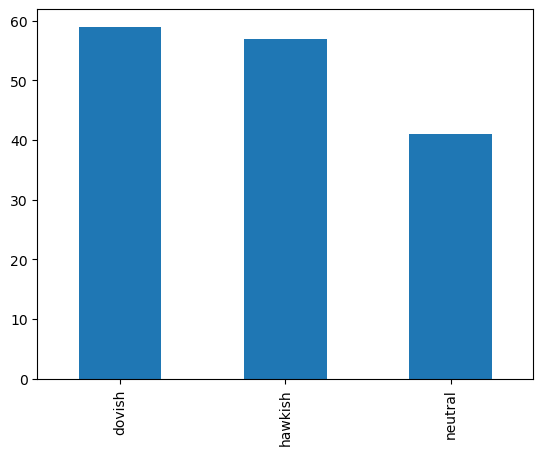

In [8]:
df_['label_hawk_dove'].value_counts().plot(kind='bar')

In [9]:
target_map = {'dovish': 0, 'neutral': 1, 'hawkish': 2}
df_['target'] = df_['label_hawk_dove'].map(target_map)

In [10]:
df = df_[['text', 'target']]
df.columns = ['sentence', 'label']
df.to_csv('data_copom_transf_en.csv', index=None)

#### Convert to dataset

In [11]:
from datasets import load_dataset

raw_dataset = load_dataset('csv', data_files='data_copom_transf_en.csv')

C:\Users\ftrav\anaconda3\envs\tcc_gpu2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Extracting data files: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 199.99it/s]


Dataset csv downloaded and prepared to C:/Users/ftrav/.cache/huggingface/datasets/csv/default-d41efd73b821a35c/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 111.09it/s]


In [12]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 157
    })
})

#### Split test and train

In [13]:
split = raw_dataset['train'].train_test_split(test_size=0.2, seed=2015)

In [14]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 125
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 32
    })
})

## Model

In [18]:
# from transformers import AutoTokenizer, AutoModelForSequenceClassification

# tokenizer = AutoTokenizer.from_pretrained("poltextlab/xlm-roberta-large-portuguese-cap")

# model = AutoModelForSequenceClassification.from_pretrained("poltextlab/xlm-roberta-large-portuguese-cap")

In [19]:
checkpoint = 'poltextlab/xlm-roberta-large-portuguese-cap'

#### Tokenizer

In [20]:
from transformers import AutoTokenizer

In [21]:
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-large')

C:\Users\ftrav\anaconda3\envs\tcc_gpu2\Lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ftrav\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [48]:
def tokenize_fn(batch):
    return tokenizer(batch['sentence'], truncation=True, padding="max_length")

In [49]:
tokenized_datasets = split.map(tokenize_fn, batched=True)

Loading cached processed dataset at C:\Users\ftrav\.cache\huggingface\datasets\csv\default-d41efd73b821a35c\0.0.0\eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d\cache-b7e57aa89bcd48fd.arrow


#### Training

In [50]:
from transformers import AutoModelForSequenceClassification,  Trainer, TrainingArguments

In [60]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels=3,
                                                           problem_type="multi_label_classification",
                                                           ignore_mismatched_sizes=True)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at poltextlab/xlm-roberta-large-portuguese-cap and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([22, 1024]) in the checkpoint and torch.Size([3, 1024]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([22]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
from torchinfo import summary

In [62]:
summary(model)

Layer (type:depth-idx)                                            Param #
XLMRobertaForSequenceClassification                               --
├─XLMRobertaModel: 1-1                                            --
│    └─XLMRobertaEmbeddings: 2-1                                  --
│    │    └─Embedding: 3-1                                        256,002,048
│    │    └─Embedding: 3-2                                        526,336
│    │    └─Embedding: 3-3                                        1,024
│    │    └─LayerNorm: 3-4                                        2,048
│    │    └─Dropout: 3-5                                          --
│    └─XLMRobertaEncoder: 2-2                                     --
│    │    └─ModuleList: 3-6                                       302,309,376
├─XLMRobertaClassificationHead: 1-2                               --
│    └─Linear: 2-3                                                1,049,600
│    └─Dropout: 2-4                                           

In [63]:
def compute_metrics(logits_and_labels):
    logits, labels = logits_and_labels
    predictions = np.argmax(logits, axis=-1)
    acc = np.mean(predictions == labels)
    f1 = f1_score(labels, predictions, average='macro')
    return {'accuracy': acc, 'f1': f1}

In [64]:
# training_args = TrainingArguments(
#     output_dir='training_dir',
#     evaluation_strategy='epoch',
#     save_strategy='epoch',
#     num_train_epochs=3,
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=8
# )

In [65]:
training_args = TrainingArguments(
    output_dir='training_dir',
    logging_dir='training_dir',
    logging_strategy='epoch',
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-06,
    seed=42,
    save_strategy='epoch',
    evaluation_strategy='epoch',
    save_total_limit=1,
    load_best_model_at_end=True
)

In [66]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [67]:
trainer.train()

ValueError: Target size (torch.Size([8])) must be the same as input size (torch.Size([8, 3]))

In [ ]:
!dir training_dir

In [ ]:
from transformers import pipeline

In [ ]:
savedmodel = pipeline('text-classification',
                      model='training_dir/checkpoint-50',
                      device=0)

In [ ]:
split['test']

In [ ]:
test_pred = savedmodel(split['test']['sentence'])

In [ ]:
test_pred

In [ ]:
split['test']['label']

In [ ]:
def get_label(d):
    return int(d['label'].split('_')[1])

test_pred = [get_label(d) for d in test_pred]

In [ ]:
print("acc:", accuracy_score(split['test']['label'], test_pred))

In [ ]:
print("f1:", f1_score(split['test']['label'], test_pred, average='macro'))

In [ ]:
# Scikit-Learn is transitioning to V1 but it's not available on Colab
# The changes modify how confusion matrices are plotted
def plot_cm(cm):
    classes = ['dovish', 'neutral', 'hawkish']
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sn.heatmap(df_cm, annot=True, fmt='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")

cm = confusion_matrix(split['test']['label'], test_pred, normalize='true')
plot_cm(cm)